In [1]:
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
stock_data_file_name = '0050.TW.csv'
data_stock = pd.read_csv(stock_data_file_name)
data_stock['Date'] = pd.to_datetime(data_stock['Date'])

In [3]:
data_dividend = pd.read_csv('0050_dividend.csv')
data_dividend.iloc[0, 2] = 0.7
data_dividend['Date'] = pd.to_datetime(data_dividend['Date'])
data_dividend = data_dividend[['Date', 'Cash Dividend']]
data_dividend.columns = ['Date', 'Dividends']
data_dividend = data_dividend[data_stock['Date'].min() < data_dividend['Date']]
data_dividend.head()

,Date,Dividends
0,2020-07-21,0.7
1,2020-01-31,2.9
2,2019-07-19,0.7
3,2019-01-22,2.3
4,2018-07-23,0.7


In [4]:
data_stock = data_stock.dropna()

In [5]:
data = data_stock.set_index('Date').join(data_dividend.set_index('Date'), on='Date')

In [6]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends
Date,,,,,,,
2007-12-31,61.450001,61.700001,61.049999,61.450001,49.378479,2870000.0,NaN
2008-01-02,60.099998,61.299999,60.000000,60.099998,48.293678,4975000.0,NaN
2008-01-03,59.099998,59.349998,58.599998,59.099998,47.490124,7413000.0,NaN
2008-01-04,59.099998,59.349998,58.049999,59.099998,47.490124,7686000.0,NaN
2008-01-07,56.400002,57.599998,56.299999,56.400002,45.320530,20041000.0,NaN


In [7]:
class StockProcess:
    def __init__(self):
        self.stock = deque()
        self.total_stock = 0
        self.total_cost = 0
        self.money_cost = 0
        
    def buy(self, price, count):
        self.stock.append((price, count))
        self.total_stock += count
        self.total_cost += price * count
        self.money_cost += price * count + 20
        
    def get_divident(self, divident):
        total = divident * self.total_stock
        self.total_cost -= total
        return total
        
    def avg_cost(self):
        return self.total_cost/self.total_stock
    
    def compute_value(self, stock_price):
        return stock_price * self.total_stock
    
    def return_rate(self, stock_price):
        if self.total_stock:
            return stock_price * self.total_stock / self.money_cost - 1
        return 0

In [8]:
litte_c = StockProcess()
start_date = pd.to_datetime('2008-01-01')
end_date = pd.to_datetime('2020-10-25')
money = 10000
return_rate_list = []
data['return_rate'] = 0

fix_buy_count = False

for day, price in data.iterrows():
    if start_date < day <= end_date:
        if not np.isnan(price['Dividends']):
            total_div = litte_c.get_divident(price['Dividends'])
            print(f'Date: {day.date()}, Get divident: {total_div}')
        # 固定星期三 買
        # 依照 報酬率決定買的股數
        if day.dayofweek == 2:
            buy_price = (price['Open'] + price['Close'])/2
            return_rate = litte_c.return_rate(buy_price)
            if fix_buy_count:
                buy_count = 100
            else:
                buy_count = int(money/buy_price)
            if return_rate < 0:
                buy_count *= abs(return_rate)*3+1
            litte_c.buy(buy_price, buy_count)
    return_rate = litte_c.return_rate(price['Close'])
    data.loc[day, 'return_rate'] = return_rate


Date: 2008-10-24, Get divident: 18690.32736464236
Date: 2009-10-23, Get divident: 27396.71806699814
Date: 2010-10-25, Get divident: 80299.37974739591
Date: 2011-10-26, Get divident: 88240.85023064636
Date: 2012-10-24, Get divident: 101188.31197127863
Date: 2013-10-24, Get divident: 85814.61954660874
Date: 2014-10-24, Get divident: 111017.7965164767
Date: 2015-10-26, Get divident: 158434.7696986796
Date: 2016-07-28, Get divident: 72638.77712193882
Date: 2017-07-31, Get divident: 64563.369394537855
Date: 2018-01-29, Get divident: 209509.04666854755
Date: 2018-07-23, Get divident: 68537.26939453786
Date: 2019-01-22, Get divident: 232335.3851534815
Date: 2019-07-19, Get divident: 72829.66939453785
Date: 2020-01-31, Get divident: 309938.6160630854
Date: 2020-07-21, Get divident: 76768.56939453786


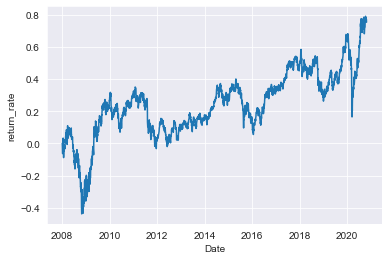

In [9]:
sns.set_style('darkgrid')
sns.lineplot(data=data, x='Date', y='return_rate')
plt.show()

In [10]:
print(f"""money cost: {litte_c.money_cost},
pure earn: {litte_c.compute_value(data.iloc[-1,:]['Close']) - litte_c.money_cost}, 
final return rate: {data.iloc[-1,:]['return_rate']}""")

money cost: 6646172.59917513,
pure earn: 5010022.810005548, 
final return rate: 0.7538207494983433
